In [16]:
from bitmind.real_fake_dataset import RealFakeDataset
from bitmind.real_image_dataset import RealImageDataset
#from bitmind.random_image_generator import RandomImageGenerator
import torchvision.transforms as transforms
import torch

real_image_dataset = RealImageDataset(huggingface_datasets=['dalle-mini/open-images'])
train_fake_image_dataset = RealImageDataset(huggingface_datasets=['imagefolder:./images/train'])
val_fake_image_dataset = RealImageDataset(huggingface_datasets=['imagefolder:./images/train'])


MEAN = {
    "imagenet":[0.485, 0.456, 0.406],
    "clip":[0.48145466, 0.4578275, 0.40821073]
}

STD = {
    "imagenet":[0.229, 0.224, 0.225],
    "clip":[0.26862954, 0.26130258, 0.27577711]
}

def CenterCrop():
    def fn(img):
        m = min(img.size)
        return transforms.CenterCrop(m)(img)
    return fn

transform = transforms.Compose([
    CenterCrop(),
    #transforms.CenterCrop(224),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: t.expand(3, -1, -1) if t.shape[0] == 1 else t),
    #transforms.Lambda(lambda t: t.float() / 255.),
    
    #transforms.Normalize( mean=MEAN['imagenet'], std=STD['imagenet'] ),
    #transforms.Lambda(lambda i: i / 1.0)
])

train_dataset = RealFakeDataset(real_image_dataset=real_image_dataset, fake_image_dataset=train_fake_image_dataset, transforms=transform)
val_dataset = RealFakeDataset(real_image_dataset=real_image_dataset, fake_image_dataset=val_fake_image_dataset, transforms=transform)

Resolving data files:   0%|          | 0/3606 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/52 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/425 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/425 [00:00<?, ?it/s]

tensor(0.0863) tensor(0.8667)


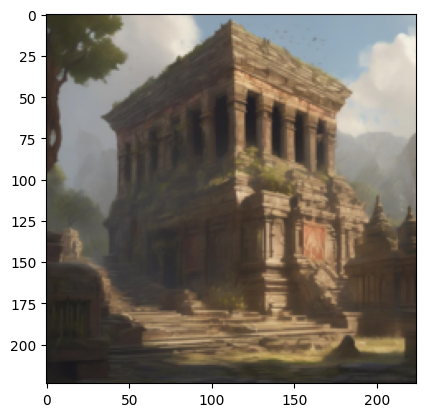

In [20]:
import matplotlib.pyplot as plt
import numpy as np
print(torch.min(train_dataset[3][0]), torch.max(train_dataset[3][0]))
plt.imshow(train_dataset[3][0].permute(1, 2, 0))

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader


In [29]:
import numpy as np
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, collate_fn=lambda d: tuple(d))
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda d: tuple(d))

# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers except the last one
for param in model.parameters():
    param.requires_grad = False

# Modify the last layer to fit your number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

#model.load_state_dict(torch.load('model.pth'))


# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Train the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

num_epochs = 10
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, batch in enumerate(train_loader):
        keep_idx = [i for i, b in enumerate(batch) if b[0].shape[0] == batch[0][0].shape[0]]
        batch = np.array(batch)
        inputs = torch.stack([b[0] for b in batch[keep_idx]])
        labels = torch.tensor([b[1] for b in batch[keep_idx]])
        inputs, labels = inputs.to(device).float(), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        outputs = nn.Sigmoid()(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
    print(f"Train Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)
    model.eval()
    correct = 0
    total = 0
    running_loss = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(val_loader):
            print(batch_idx)
            keep_idx = [i for i, b in enumerate(batch) if b[0].shape[0] == batch[0][0].shape[0]]
            batch = np.array(batch)
            inputs = torch.stack([b[0] for b in batch[keep_idx]]).to(device).float()
            labels = torch.tensor([b[1] for b in batch[keep_idx]]).to(device).long()
            outputs = model(inputs)
            outputs = nn.Sigmoid()(outputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Validation Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    epoch_loss = running_loss / len(val_dataset)
    val_losses.append(epoch_loss)
    train_losses.append(epoch_loss)
    print(f"Validation Accuracy: {accuracy:.4f}")

cuda
0


/tmp/ipykernel_151868/4055767357.py:36: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  batch = np.array(batch)
/tmp/ipykernel_151868/4055767357.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)


1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 1/10, Loss: 0.6857
0


/tmp/ipykernel_151868/4055767357.py:58: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  batch = np.array(batch)
/tmp/ipykernel_151868/4055767357.py:58: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)


1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 1/10, Loss: 0.6857
Validation Accuracy: 0.6368
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 2/10, Loss: 0.6544
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 2/10, Loss: 0.6544
Validation Accuracy: 0.8188
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 3/10, Loss: 0.6217
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 3/10, Loss: 0.6217
Validation Accuracy: 0.8353
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 4/10, Loss: 0.6023
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 4/10, Loss: 0.6023
Validation Accuracy: 0.8212
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 5/10, Loss: 0.5777
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 5/10, Loss: 0.5777
Validation Accuracy: 0.8329
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 6/10, Loss: 0.5633
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 6/10, Loss: 0.5633
Validation Accuracy: 0.8871
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 7/10, Loss: 0.5510
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 7/10, Loss: 0.5510
Validation Accuracy: 0.8800
0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 8/10, Loss: 0.5373
0
1
2
3


In [43]:
torch.save(model.state_dict(), 'model.pth')

In [37]:
test_fake_image_dataset = RealImageDataset(huggingface_datasets=['imagefolder:./images/test'])
test_dataset = RealFakeDataset(real_image_dataset=real_image_dataset, fake_image_dataset=test_fake_image_dataset, transforms=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, collate_fn=lambda d: tuple(d))


Resolving data files:   0%|          | 0/538 [00:00<?, ?it/s]

In [41]:
train_loader[0]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 train_loader[0]                                                                              │
│   2                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: 'DataLoader' object is not subscriptable

In [47]:
model.eval()
correct = 0
total = 0
running_loss = 0
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        print(batch_idx)
        keep_idx = [i for i, b in enumerate(batch) if b[0].shape[0] == batch[0][0].shape[0]]
        batch = np.array(batch)
        inputs = torch.stack([b[0] for b in batch[keep_idx]]).to(device).float()
        labels = torch.tensor([b[1] for b in batch[keep_idx]]).to(device).long()
        outputs = m(inputs)
        
        outputs = nn.Sigmoid()(outputs)
        print(outputs)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = correct / total
print(f"Validation Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
epoch_loss = running_loss / len(val_dataset)
val_losses.append(epoch_loss)
train_losses.append(epoch_loss)
print(f"Validation Accuracy: {accuracy:.4f}")

0


/tmp/ipykernel_151868/2850761785.py:9: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  batch = np.array(batch)
/tmp/ipykernel_151868/2850761785.py:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  batch = np.array(batch)


tensor([[0.7887, 0.2508],
        [0.5268, 0.5162],
        [0.1045, 0.9098],
        [0.4810, 0.6018],
        [0.2489, 0.7471],
        [0.6345, 0.2991],
        [0.7487, 0.2331],
        [0.5530, 0.4840],
        [0.5710, 0.4345],
        [0.0441, 0.9501],
        [0.3090, 0.5887],
        [0.8940, 0.1521],
        [0.3401, 0.7095],
        [0.0438, 0.9523],
        [0.5591, 0.4157],
        [0.1137, 0.8821],
        [0.0880, 0.9238],
        [0.6950, 0.2485],
        [0.0366, 0.9819],
        [0.3712, 0.6020],
        [0.2609, 0.7413],
        [0.4696, 0.5201],
        [0.0299, 0.9622],
        [0.7633, 0.2118],
        [0.2930, 0.6766],
        [0.6453, 0.3126],
        [0.6819, 0.2393],
        [0.7164, 0.3101],
        [0.2977, 0.5388],
        [0.2618, 0.6936],
        [0.6079, 0.5269],
        [0.7571, 0.3140]], device='cuda:0')
1
tensor([[0.5138, 0.4939],
        [0.1121, 0.9457],
        [0.3650, 0.6563],
        [0.1810, 0.8413],
        [0.1667, 0.8420],
        [0.4383, 0

In [44]:
# Load pre-trained ResNet50
m = models.resnet50(pretrained=True)

# Modify the last layer to fit your number of classes
num_ftrs = m.fc.in_features
m.fc = nn.Linear(num_ftrs, 2)
m.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [46]:
m = m.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 